## Drawing Dublin Electoral Districts

This is sticking closely to [this blogpost](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vyj72Z6YreQ) 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
import matplotlib
import geopandas as gp

In [282]:
import re

In [2]:
%matplotlib inline

In [3]:
shp = fiona.open('../data/interim/DublinDED_2011/dublin_ed.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
print(bds)

(-6.386966935318682, 53.29888263371935, -6.113090271214344, 53.41099255823912)


(162,
 5,
 [-6.386966935318682, 53.29888263371935, 0.0, 0.0],
 [-6.113090271214344, 53.41099255823912, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f3bb2bde898>)

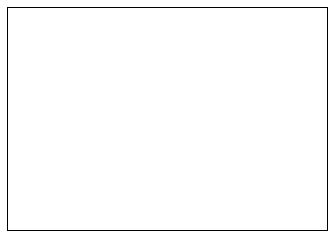

In [4]:
m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    '../data/interim/DublinDED_2011/dublin_ed',
    'dublin',
    color='none',
    zorder=2)

In [25]:
# set up a map dataframe
df_map = pd.DataFrame({
    'geometry': [Polygon(xy) for xy in m.dublin],
    'ed_name': [ed['EDNAME'] for ed in m.dublin_info],
    'geogid': [ed['GEOGID'] for ed in m.dublin_info],
    'osied': [ed['OSIED'] for ed in m.dublin_info],
    'total_area': [ed['TOTAL_AREA'] for ed in m.dublin_info]})
df_map.set_index("geogid")   
df_map.to_pickle("../data/interim/dublin_ed_basemap.pickle")

In [363]:
#save map as shapefile
gp_map = gp.GeoDataFrame(df_map)
gp_map.merge(un_df[['geogid', 'ed_name']], how="right")
gp_map.to_file('../data/interim/DublinDED/dublin_ed_test.shp')

In [70]:
tenure_df = pd.read_json("../data/interim/ten_71_81_91_02_11.json")
#convert "year" column from int64 to string - allows more clear labelling of axes
tenure_df['year'] = tenure_df['year'].astype(str)
tenure_df = tenure_df.sort_values('year')
tenure_df.rename(columns={"area": "ed_name"}, inplace=True)
tenure_df.to_pickle("../data/interim/dublin_ed_tenures_1971-2011.pickle")

In [114]:
#Pull out dataframes for year and tenure type
def dataframe_by_year(field):
    for year in tenure_df.year.unique():
        t_df = tenure_df[(tenure_df['year']==year)&(tenure_df['geogid'].str.startswith("E"))][['geogid', field, "ed_name", "total_units", "year"]]
        t_df.set_index("geogid", inplace=True)
        t_df['pc_{}'.format(field)] = t_df[field]/t_df['total_units']
        try:
            print(field, t_df.loc[t_df['pc_{}'.format(field)].idxmax()][['year', 'ed_name', 'pc_{}'.format(field)]].values)
            t_df.to_pickle("../data/interim/{}_dublin_ed_{}.pickle".format(field, year))
        except TypeError:
            print(field, year)  

In [ ]:
for k in tenure_df.keys():
    if k.endswith("units") and not k.startswith("total"):
        dataframe_by_year(k)

In [207]:
#2011 has no owner_occ data
mort2011_df = pd.read_pickle("../data/processed/tenure_pickles/owner_mortg_units_dublin_ed_2011.pickle")
#mort2011_df.set_index("geogid", inplace=True)
no_mort2011_df = pd.read_pickle("../data/processed/tenure_pickles/owner_no_mortg_units_dublin_ed_2011.pickle")
#no_mort2011_df.set_index("geogid", inplace=True)
no_mort2011_df.head(2)

,geogid,owner_no_mortg_units,ed_name,total_units,year,pc_owner_no_mortg_units
719,E02109,156.0,Kilmainham B,1039,2011,0.150144
718,E02108,308.0,Kilmainham A,1108,2011,0.277978


In [209]:
#2011 has no owner_occ data
mort2011_df = pd.read_pickle("../data/processed/tenure_pickles/owner_mortg_units_dublin_ed_2011.pickle")
no_mort2011_df = pd.read_pickle("../data/processed/tenure_pickles/owner_no_mortg_units_dublin_ed_2011.pickle")
no_mort2011_df.head(2)
own2011 = mort2011_df[['geogid', 'ed_name', 'year', 'total_units']]
own2011.set_index('geogid', inplace=True)
no_mort2011_df.set_index("geogid", inplace=True)
mort2011_df.set_index("geogid", inplace=True)

no_mort2011_df.head(2)

,owner_no_mortg_units,ed_name,total_units,year,pc_owner_no_mortg_units
geogid,,,,,
E02109,156.0,Kilmainham B,1039,2011,0.150144
E02108,308.0,Kilmainham A,1108,2011,0.277978


In [213]:
own2011['owner_occ_units'] = mort2011_df['owner_mortg_units'] + no_mort2011_df['owner_no_mortg_units']
own2011['total_units'] = mort2011_df['total_units'] + no_mort2011_df['total_units']
own2011['pc_owner_occ_units'] = own2011['owner_occ_units']/own2011['total_units']
own2011.to_pickle("../data/processed/tenure_pickles/owner_occ_units_dublin_ed_2011.pickle")

In [214]:
own2011.head()

,ed_name,year,total_units,owner_occ_units,pc_owner_occ_units
geogid,,,,,
E02109,Kilmainham B,2011,2078,453.0,0.217998
E02108,Kilmainham A,2011,2216,743.0,0.335289
E02120,Merchants Quay B,2011,3496,429.0,0.122712
E02106,Inchicore A,2011,1950,603.0,0.309231
E02110,Kilmainham C,2011,3700,892.0,0.241081


In [116]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [ ]:
import os
df_map = pd.read_pickle("../data/processed/dublin_ed_basemap.pickle")
basedir = "../data/processed/tenure_pickles"
for file in sorted(os.listdir(basedir))[:1]:
    #print(file)
    field = "pc_"+file.split("_dublin")[0]
    year = file.split("_")[-1].replace(".pickle", "")
    print(field, year)
    d_df = pd.read_pickle(os.path.join(basedir, file))
    jk_map, jenks_labels = jenks_breaks(df_map.merge(d_df), field)
    print(jenks_labels)
    highest = [(value['ed_name'], 
               value[field]*100) for _, value in df_map[(df_map['jenks_bins'] == 4)][:5].sort_index().iterrows()]
    print(highest)
    #plot_map(jk_map, field, jenks_labels, year)
    
#("../data/interim/rent_unfurn_units_dublin_ed_1971.pickle")
#df_map = pd.read_pickle("../data/interim/dublin_ed_basemap.pickle")
#df_map = df_map.merge(d_df)
#df_map.head(2)

In [361]:
#Wood Quay A consistently returns the highest percentage of unfurnished units - because of Iveagh Trust flats
un_df = pd.read_pickle("../data/processed/tenure_pickles/rent_unfurn_units_dublin_ed_1971.pickle")
un_df[un_df['ed_name']=="Wood Quay A"]

,geogid,rent_unfurn_units,ed_name,total_units,year,pc_rent_unfurn_units
609,E02161,727.0,Wood Quay A,927,1971,0.78425


In [295]:
#jk_map['status'] = jk_map['status'])
jk_map['upper'] = [int(re.search(", (\d{2,3})]$", v).group(1)) for v in jk_map['status'].fillna("(0, 20]")]
#[v  for v in jk_map['status'].unique()]

In [352]:
def fixed_breaks(df_map, field):
    bins = pd.cut(df_map[field]*100, bins=[-1, 20, 40, 60, 80, 100])
    fb = pd.DataFrame({'bins': bins}, index=df_map[df_map[field].notnull()].index)
    #print(fb)
    df_map['bins'] = [int(re.search(", (\d{2,3})]$", v).group(1)) for v in fb['bins']]
    uppers = df_map.groupby('status')[field].count()
    fixed_labels = ["{}-{}% of units ({} EDs)".format(upper_bound - 20, upper_bound, count) for upper_bound, count in zip(uppers.keys(), uppers.values)]
    fixed_labels[0] = fixed_labels[0].replace("0-", "<= ")
    return df_map, fixed_labels
nmap, labels = fixed_breaks(jk_map, field)
labels

['<= 20% of units (41 EDs)',
 '20-40% of units (16 EDs)',
 '40-60% of units (9 EDs)',
 '60-80% of units (19 EDs)',
 '80-100% of units (2 EDs)']

In [192]:
highest = '\n'.join("{} ({:0.0f}%)".format(value['ed_name'], value[field]*100) for _, value in jk_map.sort_values(field, ascending=False)[:5].iterrows())
print(highest)

Ushers B (88%)
Kimmage A (86%)
Crumlin E (79%)
Kimmage B (79%)
Kilmainham A (78%)


In [146]:
def jenks_breaks(df_map, field):
    # Calculate Jenks natural breaks for density
    breaks = nb(
        df_map[df_map[field].notnull()][field].values,
        initial=300,
        k=5)
    # the notnull method lets us match indices when joining
    jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map[field].notnull()].index)
    df_map = df_map.join(jb)
    df_map.jenks_bins.fillna(-1, inplace=True)

    jenks_labels = ["up to %0.f%% (%s EDs)" % (b*100, c) for b, c in zip(
        breaks.bins, breaks.counts)]
    #jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))
    return df_map, jenks_labels

In [151]:
def plot_map(df_map, field, labels, year):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)

    # use a blue colour ramp - we'll be converting it to a map using cmap()
    cmap = plt.get_cmap('Blues')
    # draw wards with grey outlines
    df_map['patches'] = df_map['geometry'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
    pc = PatchCollection(df_map['patches'], match_original=True)
    # impose our colour map onto the patch collection
    norm = Normalize()
    pc.set_facecolor(cmap(norm(df_map['bins'].values)))
    ax.add_collection(pc)

    # Add a colour bar
    cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.4, labels=jenks_labels)
    cb.ax.tick_params(labelsize=12)
    
    field_label = field.replace("pc_", "").replace("_", " ")

    # Show highest densities, in descending order
    highest = '\n'.join(
        "{} ({:0.0f}%)".format(value['ed_name'], value[field]*100) for _, value in df_map[(df_map['jenks_bins'] == 4)][:5].sort_index().iterrows())
    highest = 'Highest EDs by percentile:\n' + highest
    # Subtraction is necessary for precise y coordinate alignment
    details = cb.ax.text(
        -1., 0 - 0.007,
        highest,
        ha='right', va='bottom',
        size=16,
        color='#555555')

    '''
    # Bin method, copyright and source data info
    smallprint = ax.text(
        0.9, 0,
        'Classification method: natural breaks\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org',
        ha='right', va='bottom',
        size=4,
        color='#555555',
        transform=ax.transAxes)
        '''
    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.05, coords[1] + 0.001,
        coords[0], coords[1],
        5.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555',
        zorder=5)
    # this will set the image width to (a multiple of!) 722px at 100dpi
    plt.tight_layout()
    fig.set_size_inches(14.44*3, 10.5*3)
    plt.title("Percentage of {}\nby Dublin electoral division, 1981".format(field_label), fontsize=30)
    '''plt.savefig('../data/media/dublin_{}_{}.svg'.format(year, field), 
                format='svg', 
                dpi=100, 
                frameon=True, 
                bbox_inches='tight', 
                pad_inches=0.5, 
                facecolor='#F2F2F2')'''

In [24]:
[value['total_area'] for _, value in df_map[:10].sort_index().iterrows()]

[0.894163,
 0.349303,
 0.354037,
 0.484628,
 0.555836,
 0.992425,
 0.433672,
 0.946397,
 0.663706,
 0.773471]